<a href="https://colab.research.google.com/github/a-apte/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/LS_DS_234_Ridge_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Ridge Regression

Regularize your way to a better tomorrow.

# Lecture

Data science depends on math, and math is generally focused on situations where:

1. a solution exists,
2. the solution is unique,
3. the solution's behavior changes continuously with the initial conditions.

These are known as [well-posed problems](https://en.wikipedia.org/wiki/Well-posed_problem), and are the sorts of assumptions so core in traditional techniques that it is easy to forget about them. But they do matter, as there can be exceptions:

1. no solution - e.g. no $x$ such that $Ax = b$
2. multiple solutions - e.g. several $x_1, x_2, ...$ such that $Ax = b$
3. "chaotic" systems - situations where small changes in initial conditions interact and reverberate in essentially unpredictable ways - for instance, the difficulty in longterm predictions of weather (N.B. not the same thing as longterm predictions of *climate*) - you can think of this as models that fail to generalize well, because they overfit on the training data (the initial conditions)

Problems suffering from the above are called ill-posed problems. Relating to linear algebra and systems of equations, the only truly well-posed problems are those with a single unique solution.

![Intersecting lines](https://upload.wikimedia.org/wikipedia/commons/c/c0/Intersecting_Lines.svg)

Think for a moment - what would the above plot look like if there was no solution? If there were multiple solutions? And how would that generalize to higher dimensions?

A lot of what you covered with linear regression was about getting matrices into the right shape for them to be solvable in this sense. But some matrices just won't submit to this, and other problems may technically "fit" linear regression but still be violating the above assumptions in subtle ways.

[Overfitting](https://en.wikipedia.org/wiki/Overfitting) is in some ways a special case of this - an overfit model uses more features/parameters than is "justified" by the data (essentially by the *dimensionality* of the data, as measured by $n$ the number of observations). As the number of features approaches the number of observations, linear regression still "works", but it starts giving fairly perverse results. In particular, it results in a model that fails to *generalize* - and so the core goal of prediction and explanatory power is undermined.

How is this related to well and ill-posed problems? It's not clearly a no solution or multiple solution case, but it does fall in the third category - overfitting results in fitting to the "noise" in the data, which means the particulars of one random sample or another (different initial conditions )will result in dramatically different models.

## Stop and think - what are ways to address these issues?

Let's examine in the context of housing data.

In [1]:
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.preprocessing import scale

boston = load_boston()
boston.data = scale(boston.data)  # Very helpful for regularization! #Centers the mean 
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['Price'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2


In [2]:
df.shape

(506, 14)

In [3]:
# Let's try good old least squares!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df.drop('Price', axis='columns')
y = df.Price

lin_reg = LinearRegression().fit(X, y)
mean_squared_error(y, lin_reg.predict(X))

21.894831181729206

That seems like a pretty good score, but...

![Kitchen Sink](https://i.imgur.com/ZZxqhT1.jpg)

Chances are this doesn't generalize very well. You can verify this by splitting the data to properly test model validity.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)
lin_reg_split = LinearRegression().fit(X_train, y_train)
print(mean_squared_error(y, lin_reg_split.predict(X)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))

22.347018673376052
26.273991426429014


**OVERFIT VERSUS UNDERFIT**

**Overfit - Testing error is greater than overall error if you run the model on the entire dataset.**

**Overfit: Testing error is greater than training error**

**Underfit - Testing error is less than overall error if you run the model on the entire dataset.**

**Underfit: Testing error is less than training error**



Oops! 💥

### What can we do?

- Use fewer features - sure, but it can be a lot of work to figure out *which* features, and (in cases like this) there may not be any good reason to really favor some features over another.
- Get more data! This is actually a pretty good approach in tech, since apps generate lots of data all the time (and we made this situation by artificially constraining our data). But for case studies, existing data, etc. it won't work.
- **Regularize!**

## Regularization just means "add bias"

OK, there's a bit more to it than that. But that's the core intuition - the problem is the model working "too well", so fix it by making it harder for the model!

It may sound strange - a technique that is purposefully "worse" - but in certain situations, it can really get results.

What's bias? In the context of statistics and machine learning, bias is when a predictive model fails to identify relationships between features and the output. In a word, bias is *underfitting*.

We want to add bias to the model because of the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) - variance is the sensitivity of a model to the random noise in its training data (i.e. *overfitting*), and bias and variance are naturally (inversely) related. Increasing one will always decrease the other, with regards to the overall generalization error (predictive accuracy on unseen data).

Visually, the result looks like this:

![Regularization example plot](https://upload.wikimedia.org/wikipedia/commons/0/02/Regularization.svg)

The blue line is overfit, using more dimensions than are needed to explain the data and so much of the movement is based on noise and won't generalize well. The green line still fits the data, but is less susceptible to the noise - depending on how exactly we parameterize "noise" we may throw out actual correlation, but if we balance it right we keep that signal and greatly improve generalizability.

### Look carefully at the above plot and think of ways you can quantify the difference between the blue and green lines...


In [5]:
# Now with regularization via ridge regression
from sklearn.linear_model import Ridge

ridge_reg = Ridge().fit(X, y)
mean_squared_error(y, ridge_reg.predict(X))

21.895862166800143

In [6]:
# The score is a bit worse than OLS - but that's expected (we're adding bias)
# Let's try split

ridge_reg_split = Ridge().fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

26.192201358877668

In [0]:
# A little better (to same test split w/OLS) - can we improve it further?
# We just went with defaults, but as always there's plenty of parameters
help(Ridge)

Help on class Ridge in module sklearn.linear_model.ridge:

class Ridge(_BaseRidge, sklearn.base.RegressorMixin)
 |  Linear least squares with l2 regularization.
 |  
 |  Minimizes the objective function::
 |  
 |  ||y - Xw||^2_2 + alpha * ||w||^2_2
 |  
 |  This model solves a regression model where the loss function is
 |  the linear least squares function and regularization is given by
 |  the l2-norm. Also known as Ridge Regression or Tikhonov regularization.
 |  This estimator has built-in support for multi-variate regression
 |  (i.e., when y is a 2d-array of shape [n_samples, n_targets]).
 |  
 |  Read more in the :ref:`User Guide <ridge_regression>`.
 |  
 |  Parameters
 |  ----------
 |  alpha : {float, array-like}, shape (n_targets)
 |      Regularization strength; must be a positive float. Regularization
 |      improves the conditioning of the problem and reduces the variance of
 |      the estimates. Larger values specify stronger regularization.
 |      Alpha corresponds t

How to tune alpha? For now, let's loop and try values.

(For longterm/stretch/next week, check out [cross-validation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV).)

**Finding Optimal Alpha Value**

In [7]:
alphas = []
mses = []

for alpha in range(1, 201, 1):
#   alpha_dec = alpha / 10
  ridge_reg_split = Ridge(alpha=(alpha)).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)

1 26.192201358877668
2 26.118328007697226
3 26.051117952293595
4 25.989569283205444
5 25.93287356811407
6 25.880372753122625
7 25.831526788692837
8 25.785889053385123
9 25.743087513207442
10 25.702810145277628
11 25.66479356379559
12 25.628814073392263
13 25.59468057863174
14 25.56222892458644
15 25.53131734932431
16 25.50182280665663
17 25.473637974726547
18 25.44666880864133
19 25.420832527348388
20 25.396055949160893
21 25.372274108781504
22 25.349429102822004
23 25.327469121742823
24 25.30634763462536
25 25.286022699825878
26 25.266456379775086
27 25.24761424230921
28 25.229464934192976
29 25.211979815108453
30 25.19513264248022
31 25.178899299197408
32 25.163257557659424
33 25.14818687468406
34 25.13366821272317
35 25.11968388357409
36 25.106217411385522
37 25.093253412260974
38 25.080777488180427
39 25.068776133307583
40 25.057236651039766
41 25.046147080399017
42 25.035496130566347
43 25.02527312253186
44 25.015467936977434
45 25.006070967630855
46 24.997073079433843
47 24.98846

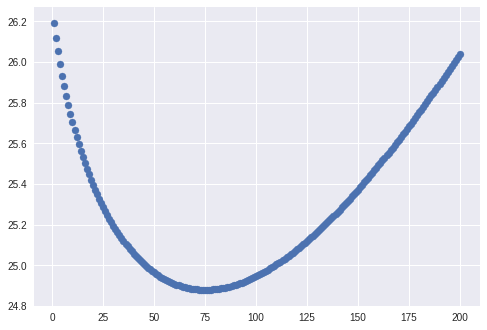

In [8]:
from matplotlib.pyplot import scatter
scatter(alphas, mses);

## What's the intuition? What are we doing?

The `alpha` parameter corresponds to the weight being given to the extra penalty being calculated by [Tikhonov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization) (this parameter is sometimes referred to as $\lambda$ in the context of ridge regression).

Normal linear regression (OLS) minimizes the **sum of square error of the residuals**.

Ridge regression minimizes the **sum of square error of the residuals** *AND* **the squared slope of the fit model, times the alpha parameter**.

This is why the MSE for the first model in the for loop (`alpha=0`) is the same as the MSE for linear regression - it's the same model!

As `alpha` is increased, we give more and more penalty to a steep slope. In two or three dimensions this is fairly easy to visualize - beyond, think of it as penalizing coefficient size. Each coefficient represents the slope of an individual dimension (feature) of the model, so ridge regression is just squaring and summing those.

So while `alpha=0` reduces to OLS, as `alpha` approaches infinity eventually the penalty gets so extreme that the model will always output every coefficient as 0 (any non-zero coefficient resulting in a penalty that outweighs whatever improvement in the residuals), and just fit a flat model with intercept at the mean of the dependent variable.

Of course, what we want is somewhere in-between these extremes. Intuitively, what we want to do is apply an appropriate "cost" or penalty to the model for fitting parameters, much like adjusted $R^2$ takes into account the cost of adding complexity to a model. What exactly is an appropriate penalty will vary, so you'll have to put on your model comparison hat and give it a go!

PS - scaling the data helps, as that way this cost is consistent and can be added uniformly across features, and it is simpler to search for the `alpha` parameter.

### Bonus - magic! ✨

Ridge regression doesn't just reduce overfitting and help with the third aspect of well-posed problems (poor generalizability). It can also fix the first two (no unique solution)!

**OVERFIT - More Features (14) than Observations (10)**

In [9]:
df_tiny = df.sample(10, random_state=27)
print(df_tiny.shape)
X = df_tiny.drop('Price', axis='columns')
y = df_tiny.Price

lin_reg = LinearRegression().fit(X, y)
lin_reg.score(X, y)  # Perfect multi-collinearity!
# NOTE - True OLS would 💥 here
# scikit protects us from actual error, but still gives a poor model

(10, 14)


1.0

In [10]:
ridge_reg = Ridge().fit(X, y)
ridge_reg.score(X, y)  # More plausible (not "perfect")

0.9760119331942763

**OLS MSE**

In [11]:
# Using our earlier test split
mean_squared_error(y_test, lin_reg.predict(X_test))

103.04429449784261

**RIDGE MSE**

In [12]:
# Ridge generalizes *way* better (and we've not even tuned alpha)
mean_squared_error(y_test, ridge_reg.predict(X_test))

41.79869373639458

## And a bit more math

The regularization used by Ridge Regression is also known as **$L^2$ regularization**, due to the squaring of the slopes being summed. This corresponds to [$L^2$ space](https://en.wikipedia.org/wiki/Square-integrable_function), a metric space of square-integrable functions that generally measure what we intuitively think of as "distance" (at least, on a plane) - what is referred to as Euclidean distance.

The other famous norm is $L^1$, also known as [taxicab geometry](https://en.wikipedia.org/wiki/Taxicab_geometry), because it follows the "grid" to measure distance like a car driving around city blocks (rather than going directly like $L^2$). When referred to as a distance this is called "Manhattan distance", and can be used for regularization (see [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics%29), which [uses the $L^1$ norm](https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization-How-does-it-solve-the-problem-of-overfitting-Which-regularizer-to-use-and-when)).

All this comes down to - regularization means increasing model bias by "watering down" coefficients with a penalty typically based on some sort of distance metric, and thus reducing variance (overfitting the model to the noise in the data). It gives us another lever to try and another tool for our toolchest!

## Putting it all together - one last example

The official scikit-learn documentation has many excellent examples - [this one](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols_ridge_variance.html#sphx-glr-auto-examples-linear-model-plot-ols-ridge-variance-py) illustrates how ridge regression effectively reduces the variance, again by increasing the bias, penalizing coefficients to reduce the effectiveness of features (but also the impact of noise).

```
Due to the few points in each dimension and the straight line that linear regression uses to follow these points as well as it can, noise on the observations will cause great variance as shown in the first plot. Every line’s slope can vary quite a bit for each prediction due to the noise induced in the observations.

Ridge regression is basically minimizing a penalised version of the least-squared function. The penalising shrinks the value of the regression coefficients. Despite the few data points in each dimension, the slope of the prediction is much more stable and the variance in the line itself is greatly reduced, in comparison to that of the standard linear regression
```

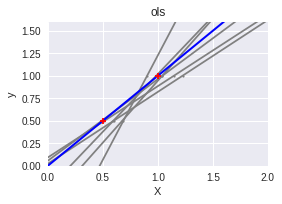

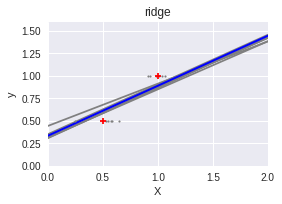

In [13]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause


import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model

X_train = np.c_[.5, 1].T
y_train = [.5, 1]
X_test = np.c_[0, 2].T

np.random.seed(0)

classifiers = dict(ols=linear_model.LinearRegression(),
                   ridge=linear_model.Ridge(alpha=.1))

for name, clf in classifiers.items():
    fig, ax = plt.subplots(figsize=(4, 3))

    for _ in range(6):
        this_X = .1 * np.random.normal(size=(2, 1)) + X_train
        clf.fit(this_X, y_train)

        ax.plot(X_test, clf.predict(X_test), color='gray')
        ax.scatter(this_X, y_train, s=3, c='gray', marker='o', zorder=10)

    clf.fit(X_train, y_train)
    ax.plot(X_test, clf.predict(X_test), linewidth=2, color='blue')
    ax.scatter(X_train, y_train, s=30, c='red', marker='+', zorder=10)

    ax.set_title(name)
    ax.set_xlim(0, 2)
    ax.set_ylim((0, 1.6))
    ax.set_xlabel('X')
    ax.set_ylabel('y')

    fig.tight_layout()

plt.show()

# Assignment

Following is data describing characteristics of blog posts, with a target feature of how many comments will be posted in the following 24 hours.

https://archive.ics.uci.edu/ml/datasets/BlogFeedback

Investigate - you can try both linear and ridge. You can also sample to smaller data size and see if that makes ridge more important. Don't forget to scale!

Focus on the training data, but if you want to load and compare to any of the test data files you can also do that.

Note - Ridge may not be that fundamentally superior in this case. That's OK! It's still good to practice both, and see if you can find parameters or sample sizes where ridge does generalize and perform better.

When you've fit models to your satisfaction, answer the following question:

```
Did you find cases where Ridge performed better? If so, describe (alpha parameter, sample size, any other relevant info/processing). If not, what do you think that tells you about the data?
```

You can create whatever plots, tables, or other results support your argument. In this case, your target audience is a fellow data scientist, *not* a layperson, so feel free to dig in!

In [14]:
# TODO - write some code!

!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip
!unzip BlogFeedback.zip

--2019-01-25 03:11:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2583605 (2.5M) [application/zip]
Saving to: ‘BlogFeedback.zip’

BlogFeedback.zip    100%[===================>]   2.46M  3.30MB/s    in 0.7s    

2019-01-25 03:11:23 (3.30 MB/s) - ‘BlogFeedback.zip’ saved [2583605/2583605]

Archive:  BlogFeedback.zip
  inflating: blogData_test-2012.02.01.00_00.csv  
  inflating: blogData_test-2012.02.02.00_00.csv  
  inflating: blogData_test-2012.02.03.00_00.csv  
  inflating: blogData_test-2012.02.04.00_00.csv  
  inflating: blogData_test-2012.02.05.00_00.csv  
  inflating: blogData_test-2012.02.06.00_00.csv  
  inflating: blogData_test-2012.02.07.00_00.csv  
  inflating: blogData_test-2012.02.08.00_00.csv  
  inflating: blogData_test-20

#### Attribute Information:

1...50: 
Average, standard deviation, min, max and median of the 
Attributes 51...60 for the source of the current blog post 
With source we mean the blog on which the post appeared. 
For example, myblog.blog.org would be the source of 
the post myblog.blog.org/post_2010_09_10 

51: Total number of comments before basetime 

52: Number of comments in the last 24 hours before the 
basetime 

53: Let T1 denote the datetime 48 hours before basetime, 
Let T2 denote the datetime 24 hours before basetime. 
This attribute is the number of comments in the time period 
between T1 and T2 

54: Number of comments in the first 24 hours after the 
publication of the blog post, but before basetime 

55: The difference of Attribute 52 and Attribute 53 

56...60: 
The same features as the attributes 51...55, but 
features 56...60 refer to the number of links (trackbacks), 
while features 51...55 refer to the number of comments. 

61: The length of time between the publication of the blog post 
and basetime 

62: The length of the blog post 

63...262: 
The 200 bag of words features for 200 frequent words of the 
text of the blog post 

263...269: binary indicator features (0 or 1) for the weekday 
(Monday...Sunday) of the basetime 

270...276: binary indicator features (0 or 1) for the weekday 
(Monday...Sunday) of the date of publication of the blog 
post 

277: Number of parent pages: we consider a blog post P as a 
parent of blog post B, if B is a reply (trackback) to 
blog post P. 

278...280: 
Minimum, maximum, average number of comments that the 
parents received 

281: The target: the number of comments in the next 24 hours 
(relative to basetime)



#### Loading  and Cleaning Data

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-whitegrid')
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

import timeit

In [157]:
numbers = list(range(1,282))
col_names = []

for number in numbers:
  col_names.append(str(number))

df_raw = pd.read_csv('blogData_train.csv', header=None, names = col_names)

print (df_raw.shape)

df_raw.head()

(52397, 281)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281
0,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,14.044226,32.615417,0.0,377.0,2.0,34.567566,48.475178,0.0,378.0,12.0,1.479934,46.18691,-356.0,377.0,0.0,1.076167,1.795416,0.0,11.0,0.0,0.400491,1.078097,0.0,9.0,0.0,0.377559,1.07421,0.0,9.0,0.0,0.972973,1.704671,0.0,10.0,0.0,0.022932,1.521174,-8.0,9.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,14.044226,32.615417,0.0,377.0,2.0,34.567566,48.475178,0.0,378.0,12.0,1.479934,46.18691,-356.0,377.0,0.0,1.076167,1.795416,0.0,11.0,0.0,0.400491,1.078097,0.0,9.0,0.0,0.377559,1.07421,0.0,9.0,0.0,0.972973,1.704671,0.0,10.0,0.0,0.022932,1.521174,-8.0,9.0,0.0,6.0,2.0,4.0,5.0,-2.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.44188,0.0,377.0,3.0,14.044226,32.615417,0.0,377.0,2.0,34.567566,48.475178,0.0,378.0,12.0,1.479934,46.18691,-356.0,377.0,0.0,1.076167,1.795416,0.0,11.0,0.0,0.400491,1.078097,0.0,9.0,0.0,0.377559,1.07421,0.0,9.0,0.0,0.972973,1.704671,0.0,10.0,0.0,0.022932,1.521174,-8.0,9.0,0.0,6.0,2.0,4.0,5.0,-2.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [0]:

# df_raw_test = pd.read_csv('blogData_test-2012.03.31.01_00.csv', header=None, names = col_names)

# print (df_raw_test.shape)

# df_raw_test.head()

In [0]:
# df_raw.describe().T

In [0]:
df = pd.DataFrame(scale(df_raw))
# df_test = pd.DataFrame(scale(df_raw_test))

df.columns = col_names
# df_test.columns = col_names

df = df.drop('281', axis='columns')
# df_test = df_test.drop('281', axis='columns')

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52397 entries, 0 to 52396
Columns: 280 entries, 1 to 280
dtypes: float64(280)
memory usage: 111.9 MB


In [160]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
1,52397.0,1.735776e-17,1.00001,-0.498529,-0.469640,-0.364170,0.010876,13.690696
2,52397.0,-1.692382e-16,1.00001,-0.750596,-0.666979,-0.440248,0.491283,8.220507
3,52397.0,-9.763742e-18,1.00001,-0.052468,-0.052468,-0.052468,-0.052468,106.077771
4,52397.0,4.339441e-17,1.00001,-0.769898,-0.704202,-0.402906,0.312956,3.860550
5,52397.0,4.339441e-18,1.00001,-0.354630,-0.354630,-0.297158,-0.139108,18.525138
6,52397.0,6.075217e-17,1.00001,-0.471758,-0.444113,-0.343058,0.024309,13.253965
7,52397.0,-4.339441e-17,1.00001,-0.724638,-0.644939,-0.438215,0.459833,8.593561
8,52397.0,-1.084860e-18,1.00001,-0.020836,-0.020836,-0.020836,-0.020836,106.118918
9,52397.0,-4.339441e-17,1.00001,-0.804948,-0.736486,-0.428406,0.399365,3.626426
10,52397.0,8.678881e-18,1.00001,-0.245251,-0.245251,-0.203178,-0.161105,24.493800


In [0]:
# df_test.describe().T

In [0]:
# Remove potentially problematic features (all values = 0)

drop_cols = ['13','33','38','278']
df = df.drop(drop_cols, axis='columns')

## Regression Modeling

####Entire Dataset (52397 observations, 280 features)

In [171]:
# df_sample = df.sample(5000)

y = df_raw['281']
X = df
# X = df.drop('281', axis='columns')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=237)

print (y.shape, y_train.shape, y_test.shape, X.shape, X_train.shape, X_test.shape)

(52397,) (41917,) (10480,) (52397, 276) (41917, 276) (10480, 276)




---



**OLS**

In [172]:
lin_reg = LinearRegression().fit(X, y)
print("MSE:",mean_squared_error(y, lin_reg.predict(X)))
print("Score:",lin_reg.score(X, y))

MSE: 903.1580630151177
Score: 0.3647595853837773


**Training Set**

In [173]:
lin_reg2 = LinearRegression().fit(X_train, y_train)
print("MSE:",mean_squared_error(y_train, lin_reg2.predict(X_train)))
print("Score:",lin_reg2.score(X_train, y_train))

MSE: 960.9430300883797
Score: 0.3650640784498643


**Testing Set**

In [174]:
print("MSE:",mean_squared_error(y_test, lin_reg2.predict(X_test)))
print("Score:",lin_reg2.score(X_test, y_test))

MSE: 691.9498286608359
Score: 0.3439503825653222


**The train-test split of 4/1 train/test results in numbers that are not garbage. **



---



**RIDGE**

In [175]:
ridge_reg = Ridge().fit(X, y)
print("MSE:",mean_squared_error(y, ridge_reg.predict(X)))
print("Score:",ridge_reg.score(X, y))

MSE: 903.2827764120972
Score: 0.36467186763729453


**Training Set**

15000 682.0072539415582
15500 681.911405939457
16000 681.8238196277756
16500 681.744210595291
17000 681.6723063465662
17500 681.6078456237668
18000 681.5505777870549
18500 681.5002622457774
19000 681.4566679340493
19500 681.4195728254205
20000 681.3887634821926
20500 681.3640346356561
21000 681.3451887940786
21500 681.3320358757455
22000 681.3243928647266
22500 681.3220834873536
23000 681.3249379076588
23500 681.3327924402282
24000 681.3454892791149
24500 681.3628762416042
25000 681.3848065257533
25500 681.411138480737
26000 681.4417353891308
26500 681.4764652603395
27000 681.5152006344557
27500 681.5578183958892
28000 681.6041995961722
28500 681.654229285383
29000 681.7077963516841
29500 681.7647933685014
30000 681.8251164489126


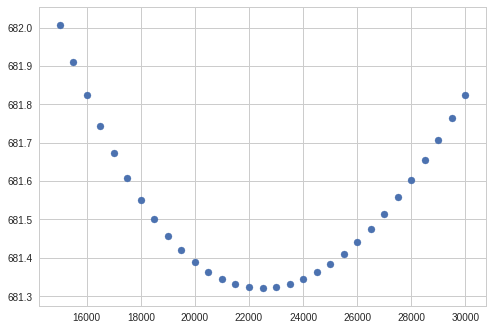

In [176]:
alpha_candidates = [1,10,100,1000,10000,10**6]
alpha_candidates2 = [5000, 10000,15000,20000,25000,30000,35000,40000,45000,50000]

alphas = []
mses = []

for alpha in range(15000, 30001, 500):
# for alpha in alpha_candidates2:
#   alpha_dec = alpha / 10
  ridge_reg_split = Ridge(alpha=(alpha)).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)
  
plt.scatter(alphas, mses);

plt.show()

In [177]:
alpha = 22500

ridge_reg2 = Ridge(alpha=alpha).fit(X_train, y_train)
print("MSE:",mean_squared_error(y_train, ridge_reg2.predict(X_train)))
print("Score:",ridge_reg2.score(X_train, y_train))

MSE: 983.1018822661009
Score: 0.3504227825692328


**Testing Set**

In [178]:
print("MSE:",mean_squared_error(y_test, ridge_reg2.predict(X_test)))
print("Score:",ridge_reg2.score(X_test, y_test))

MSE: 681.3220834873536
Score: 0.35402673184161326


**There is a clear underfit that exists with these model but it's the tradeoff one needs to get values that make sense.**

#### SAMPLING

In [179]:
df_sample = pd.concat([df,df_raw['281']], axis='columns')

df_sample['281']

df_sample = df_sample.sample(10480) # Ten percent of the data set

y = df_sample['281']
X = df_sample.drop('281', axis='columns')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=237)

print (y.shape, y_train.shape, y_test.shape, X.shape, X_train.shape, X_test.shape)

(10480,) (8384,) (2096,) (10480, 276) (8384, 276) (2096, 276)




---



**OLS**

In [180]:
lin_reg = LinearRegression().fit(X, y)
print("MSE:",mean_squared_error(y, lin_reg.predict(X)))
print("Score:",lin_reg.score(X, y))

MSE: 990.6937462229913
Score: 0.3725275037530841


**Training Set**

In [181]:
lin_reg2 = LinearRegression().fit(X_train, y_train)
print("MSE:",mean_squared_error(y_train, lin_reg2.predict(X_train)))
print("Score:",lin_reg2.score(X_train, y_train))

MSE: 1080.093756521422
Score: 0.3737182231623826


**Testing Set**

In [182]:
print("MSE:",mean_squared_error(y_test, lin_reg2.predict(X_test)))
print("Score:",lin_reg2.score(X_test, y_test))

MSE: 1.258917814407056e+24
Score: -1.265628838159591e+21




---



**RIDGE**

In [183]:
ridge_reg = Ridge().fit(X, y)
print("MSE:",mean_squared_error(y, ridge_reg.predict(X)))
print("Score:",ridge_reg.score(X, y))

MSE: 995.8290082338721
Score: 0.3692749994497774


**Training Set**

5000 637.4233884208093
5100 637.3582968660361
5200 637.3007313967685
5300 637.250419740341
5400 637.2071016928717
5500 637.170528439557
5600 637.140461922342
5700 637.1166742509924
5800 637.0989471539847
5900 637.0870714659784
6000 637.0808466489486
6100 637.0800803443226
6200 637.0845879537159
6300 637.0941922460798
6400 637.1087229892719
6500 637.1280166042268
6600 637.1519158400791
6700 637.180269468714
6800 637.2129319973658
6900 637.2497633979874
7000 637.2906288522267
7100 637.3353985109376
7200 637.3839472672382
7300 637.4361545422103
7400 637.4919040823995
7500 637.5510837683474
7600 637.613585433438
7700 637.679304692403
7800 637.7481407788704
7900 637.8199963913935
8000 637.8947775474354
8100 637.9723934448197
8200 638.0527563301978
8300 638.1357813741095
8400 638.2213865522482
8500 638.3094925325657
8600 638.4000225678725
8700 638.4929023936246
8800 638.5880601305956
8900 638.6854261921593
9000 638.7849331959268
9100 638.8865158794918
9200 638.9901110200653
9300 639.09565735

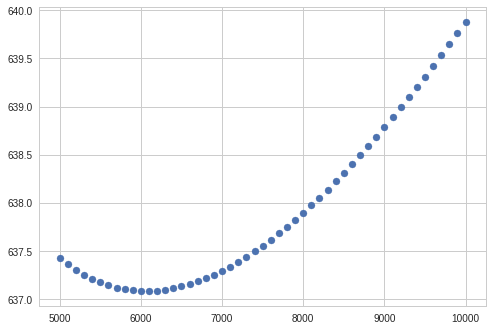

In [192]:
alpha_candidates = [1,10,100,1000,10000,100000,10**6]
alpha_candidates2 = [5000, 10000,15000,20000,25000,30000,35000,40000,45000,50000]

alphas = []
mses = []

for alpha in range(5000, 10001, 100):
# for alpha in alpha_candidates2:
#   alpha_dec = alpha / 10
  ridge_reg_split = Ridge(alpha=(alpha)).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)
  
plt.scatter(alphas, mses);

plt.show()

In [193]:
alpha = 6100

ridge_reg2 = Ridge(alpha=alpha).fit(X_train, y_train)
print("MSE:",mean_squared_error(y_train, ridge_reg2.predict(X_train)))
print("Score:",ridge_reg2.score(X_train, y_train))

MSE: 1153.786169165063
Score: 0.3309884000787372


**Testing Set**

In [194]:
print("MSE:",mean_squared_error(y_test, ridge_reg2.predict(X_test)))
print("Score:",ridge_reg2.score(X_test, y_test))

MSE: 637.0800803443226
Score: 0.3595237809224501


**When dealing with a sample of the full datset (20%) and a train/test split of 4/1, one sees that as the number of test observations decreases, the worse the model predicts. At 20% of the data and 4/1 train/test, the model has underfit but it produces values that make sense. The optimal alpha changes with number of observations. **

#### FEATURE REMOVAL (OVERFIT SOLUTION)

In [0]:
cols_attributes = ['51','52','53','54','55','56','57','58','59','60','61','62',
                   '263','264','265','266','267','268', '270','271','272','273','274','275','277']


cols_bag_of_words = [str(i) for i in range(63,263)]

# cols_bag_of_words[-1]

df_attributes = df[cols_attributes]
df_bow = df[cols_bag_of_words]

**ATTRIBUTES ONLY**

In [196]:
y = df_raw['281']
X = df_attributes
# X = df.drop('281', axis='columns')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=237)

print (y.shape, y_train.shape, y_test.shape, X.shape, X_train.shape, X_test.shape)

(52397,) (41917,) (10480,) (52397, 25) (41917, 25) (10480, 25)




---



**OLS**

In [197]:
lin_reg = LinearRegression().fit(X, y)
print("MSE:",mean_squared_error(y, lin_reg.predict(X)))
print("Score:",lin_reg.score(X, y))

MSE: 1089.316797093976
Score: 0.23382397592257312


**Training Set**

In [198]:
lin_reg2 = LinearRegression().fit(X_train, y_train)
print("MSE:",mean_squared_error(y_train, lin_reg2.predict(X_train)))
print("Score:",lin_reg2.score(X_train, y_train))

MSE: 1164.5640847968646
Score: 0.2305229891550581


**Testing Set**

In [199]:
print("MSE:",mean_squared_error(y_test, lin_reg2.predict(X_test)))
print("Score:",lin_reg2.score(X_test, y_test))

MSE: 790.4430529384954
Score: 0.2505672506808593




---



**RIDGE**

In [200]:
ridge_reg = Ridge().fit(X, y)
print("MSE:",mean_squared_error(y, ridge_reg.predict(X)))
print("Score:",ridge_reg.score(X, y))

MSE: 1089.320270575393
Score: 0.23382153283330034


**Training Set**

2000 787.7666388657931
2100 787.750489900867
2200 787.7363514658032
2300 787.7240113076537
2400 787.7132872889623
2500 787.7040223716506
2600 787.6960805773007
2700 787.689343706322
2800 787.6837086526067
2900 787.6790851896673
3000 787.675394133209
3100 787.6725658066262
3200 787.6705387520659
3300 787.6692586419493
3400 787.6686773551871
3500 787.6687521895361
3600 787.669445187142
3700 787.670722554683
3800 787.6725541629932
3900 787.674913113764
4000 787.6777753631261
4100 787.6811193936526
4200 787.6849259277551
4300 787.6891776765914
4400 787.6938591195459
4500 787.6989563101199
4600 787.7044567047027
4700 787.710349011227
4800 787.7166230551508
4900 787.7232696605765
5000 787.7302805446262


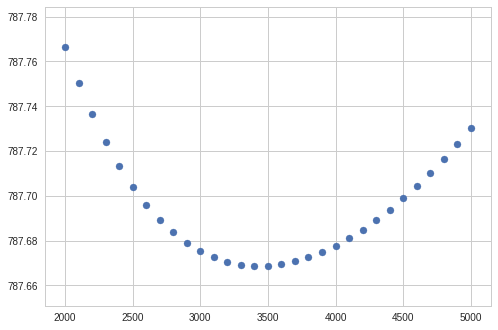

In [201]:
alpha_candidates = [1,10,100,1000,10000,10**6]
alpha_candidates2 = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]

alphas = []
mses = []

for alpha in range(2000, 5001, 100):
# for alpha in alpha_candidates2:
#   alpha_dec = alpha / 10
  ridge_reg_split = Ridge(alpha=(alpha)).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)
  
plt.scatter(alphas, mses);
plt.show()

In [202]:
alpha = 3400

ridge_reg2 = Ridge(alpha=alpha).fit(X_train, y_train)
print("MSE:",mean_squared_error(y_train, ridge_reg2.predict(X_train)))
print("Score:",ridge_reg2.score(X_train, y_train))

MSE: 1169.3741834670154
Score: 0.22734475242691565


**Testing Set**

In [203]:
print("MSE:",mean_squared_error(y_test, ridge_reg2.predict(X_test)))
print("Score:",ridge_reg2.score(X_test, y_test))

MSE: 787.6686773551871
Score: 0.253197684224823


**The alpha dropped as the number of features dropped.**

**BAG OF WORDS**

In [204]:
y = df_raw['281']
X = df_bow
# X = df.drop('281', axis='columns')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=237)

print (y.shape, y_train.shape, y_test.shape, X.shape, X_train.shape, X_test.shape)

(52397,) (41917,) (10480,) (52397, 200) (41917, 200) (10480, 200)




---



**OLS**

In [205]:
lin_reg = LinearRegression().fit(X, y)
print("MSE:",mean_squared_error(y, lin_reg.predict(X)))
print("Score:",lin_reg.score(X, y))

MSE: 1384.0276540785685
Score: 0.026537727092769914


**Training Set**

In [206]:
lin_reg2 = LinearRegression().fit(X_train, y_train)
print("MSE:",mean_squared_error(y_train, lin_reg2.predict(X_train)))
print("Score:",lin_reg2.score(X_train, y_train))

MSE: 1473.7541399807358
Score: 0.02622797220254114


**Testing Set**

In [207]:
print("MSE:",mean_squared_error(y_test, lin_reg2.predict(X_test)))
print("Score:",lin_reg2.score(X_test, y_test))

MSE: 1031.786384795542
Score: 0.021745457572454385




---



**RIDGE**

In [208]:
ridge_reg = Ridge().fit(X, y)
print("MSE:",mean_squared_error(y, ridge_reg.predict(X)))
print("Score:",ridge_reg.score(X, y))

MSE: 1384.0121919518117
Score: 0.026548602451374248


**Training Set**

5000 1030.5009672147846
5500 1030.4374207205528
6000 1030.3814697031735
6500 1030.332572743004
7000 1030.2902346852086
7500 1030.254001496128
8000 1030.2234558707687
8500 1030.1982134519426
9000 1030.177919552848
9500 1030.16224629807
10000 1030.1508901154473
10500 1030.1435695245202
11000 1030.140023177539
11500 1030.1400081169677
12000 1030.1432982197196
12500 1030.1496828033332
13000 1030.158965373316
13500 1030.1709624941145
14000 1030.185502768816
14500 1030.2024259148504
15000 1030.221581924769
15500 1030.24283030266
16000 1030.2660393680237
16500 1030.2910856199846
17000 1030.317853155612
17500 1030.3462331368887
18000 1030.3761233015096
18500 1030.407427513273
19000 1030.4400553482888
19500 1030.4739217136657
20000 1030.5089464956998


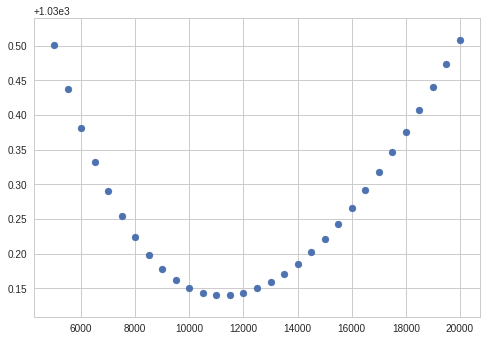

In [209]:
alpha_candidates = [1,10,100,1000,10000,100000, 10**6]
alpha_candidates2 = [5000,10000,15000,20000,25000,30000,35000,40000,45000,50000]

alphas = []
mses = []

for alpha in range(5000, 20001, 500):
# for alpha in alpha_candidates2:
#   alpha_dec = alpha / 10
  ridge_reg_split = Ridge(alpha=(alpha)).fit(X_train, y_train)
  mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
  print(alpha, mse)
  alphas.append(alpha)
  mses.append(mse)
  
plt.scatter(alphas, mses);
plt.show()

In [210]:
alpha = 11500

ridge_reg2 = Ridge(alpha=alpha).fit(X_train, y_train)
print("MSE:",mean_squared_error(y_train, ridge_reg2.predict(X_train)))
print("Score:",ridge_reg2.score(X_train, y_train))

MSE: 1475.380419984653
Score: 0.025153419850680314


**Testing Set**

In [211]:
print("MSE:",mean_squared_error(y_test, ridge_reg2.predict(X_test)))
print("Score:",ridge_reg2.score(X_test, y_test))

MSE: 1030.1400081169677
Score: 0.023306415817393233


** It appears that the bag-of-words variables don't provide much to the model. At the optimum alpha, ridge regression beats OLS. **

## DISCUSSION

        Did you find cases where Ridge performed better? If so, describe (alpha parameter, sample size, any other relevant info/processing). If not, what do you think that tells you about the data?
        
**With a found "optimum" alpha in the model, ridge regression outperforms OLS in every case. Reducing the number of features increases the MSE and lowers the regression score. Reducing the number of observations actually produces garbage values in OLS yet Ridge Regression handles it fine. The caveat in this analysis is that every result suggests underfit.**

# Resources and stretch goals

Resources:
- https://www.quora.com/What-is-regularization-in-machine-learning
- https://blogs.sas.com/content/subconsciousmusings/2017/07/06/how-to-use-regularization-to-prevent-model-overfitting/
- https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/
- https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
- https://stats.stackexchange.com/questions/111017/question-about-standardizing-in-ridge-regression#111022

Stretch goals:
- Revisit past data you've fit OLS models to, and see if there's an `alpha` such that ridge regression results in a model with lower MSE on a train/test split
- Yes, Ridge can be applied to classification! Check out [sklearn.linear_model.RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier), and try it on a problem you previous approached with a different classifier (note - scikit LogisticRegression also automatically penalizes based on the $L^2$ norm, so the difference won't be as dramatic)
- Implement your own function to calculate the full cost that ridge regression is optimizing (the sum of squared residuals + `alpha` times the sum of squared coefficients) - this alone won't fit a model, but you can use it to verify cost of trained models and that the coefficients from the equivalent OLS (without regularization) may have a higher cost